# Prédiction de la consommation en énergie

### Préparation de l'environnement et chargement des données

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Models selections

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Métriques 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Standardisation 
from sklearn.preprocessing import StandardScaler

# Modèles linéaires
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Modèle de Support Vector Machin
from sklearn.svm import SVR

# Modèles ensemblistes 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

import xgboost as xgb


# Modèle de régression KNN
from sklearn.neighbors import KNeighborsRegressor

# Modèle dummy 
from sklearn.dummy import DummyRegressor

# Modèle deep learning (perceptron multi-couches) 
from sklearn.neural_network import MLPRegressor

# Feature Selection
import shap

#Timer
from timeit import default_timer as timer


In [2]:
def Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=3, n_jobs = -1, randomized_cv = False,random_state_cv = 0, randomized_n_iter = 10) :
    """ Cette fonction permet de tester et comparer en parallèle de nombreux modèles en utilisant la validation croisée. 
    Entrées : les Données d'entrainement (X et y), les données de test (X et y), un dictionnaire de paramètre (détaillé ci-dessous), 
              le nombre de 'fold' pour la validation croisée, le nombre de coeurs alloués (-1 : tous les coeurs).
              L'argument randomized_cv = True permet de lancer RandomizedSearchCV à la place de GridsearchCV. 
              Le random-state et le nombre d'itérations peuvent ensuite etre renseignés.
    Sortie : un dataframe contenant les modèles,les paramètres optimaux ,les top scores (R2) sur les données d'entrainements,
             le temps d'entrainement (lié à l'algorithme et au nombre d'hyperparamètre testé),
             le R2, MSE, RMSE et MAE des données de test. 

    Format du dictionnaire param_grid :

    param_grid ={
    'GradientBoosting_Reg' : 
        {
        'model' : GradientBoostingRegressor(),
        'params' : {
            'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators': np.linspace(10, 200, 20,dtype=int)
                    }
        }, 
    'Lasso':{
        'model' : Lasso(),
        'params' : {
           'alpha': np.linspace(0.1, 5, 10),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
        }
    }
    """
    
    scores=[]


    for model_name,mp in param_grid.items():
        if randomized_cv:
            model_compare = RandomizedSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs,random_state = random_state_cv, n_iter=randomized_n_iter)

        else: 
            model_compare = GridSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs)

        start = timer()
        model_compare.fit(X_train,y_train)
        end = timer()
        y_pred=model_compare.predict(X_test)
        scores.append({
            'model' : model_name,
            'top_params' : str(model_compare.best_params_),
            'top_score_train' : model_compare.best_score_.round(3),
            'fit_time' : end-start,
            'R2_test' : r2_score(y_test,y_pred).round(3),
            'MSE_test' : mean_squared_error(y_test,y_pred,squared=False).round(3),
            'RMSE_test' : mean_squared_error(y_test,y_pred).round(3),
            'MAE_test' : round(np.mean(abs(y_pred - y_test)), 3)
        })

    output = pd.DataFrame(scores).copy()
    
    return output

In [3]:
df=  pd.read_csv("2016_Building_Energy_Benchmarking_model.csv",sep=';')


### Comparaison des différents modèles

In [4]:
#Préparation d'un dictionnaire des paramètres pour la fonction regression_comparison
param_grid ={
    'Dummy_regression':{
        'model' : DummyRegressor(),
        'params' : {
            'strategy' : ['mean']
                    }
    },
    'linear_regression':{
        'model' : LinearRegression(),
        'params' : {
                    }
    },
    'Ridge':{
        'model' : Ridge(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                }
    },
    'Lasso':{
        'model' : Lasso(random_state=0),
        'params' : {
           'alpha': np.linspace(0.001, 10, 30),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
    },
    'ElasticNet':{
        'model' : ElasticNet(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                    }
    },
    'SVR':{
        'model' : SVR(),
        'params' : {
        'C' : np.logspace(-2, 3, 6),
        'gamma' : np.logspace(-2, 1, 4)
                }
    },
    'KNN' : {
        'model' : KNeighborsRegressor(),
        'params' : {
        'n_neighbors':[3, 5, 7, 9, 11, 13, 15]  
            }
    },
    'Bagging_Reg' : {
        'model' : BaggingRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         },
    },
    'random_forest' : {
        'model' : RandomForestRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         }
    },
    'AdaBoost_Reg' : {
        'model' : AdaBoostRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(3, 1000, 20,dtype=int)
         }
    },
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    },
    'XGBoost_reg' : {
        'model' : xgb.XGBRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 20,dtype=int)
         }
    },
    'Perceptron_reg' : {
        'model' : MLPRegressor(random_state=0),
        'params' : {
            'max_iter':[2000],
           # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
                    }
    },
}

In [5]:

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df.dropna()['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

Scores_Electricity = Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=3)
Scores_Electricity

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.005,7.328992,-0.008,1.103,1.217,0.918
1,linear_regression,{},0.842,1.280900,0.850,0.425,0.181,0.294
2,Ridge,{'alpha': 1.3801724137931035},0.845,0.483694,0.852,0.422,0.178,0.289
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.847,0.464039,0.851,0.424,0.180,0.289
4,ElasticNet,{'alpha': 0.001},0.847,0.291059,0.852,0.423,0.179,0.289
5,SVR,"{'C': 10.0, 'gamma': 0.01}",0.405,2.551224,0.594,0.700,0.490,0.545
6,KNN,{'n_neighbors': 9},0.309,0.146597,0.354,0.883,0.780,0.703
7,Bagging_Reg,{'n_estimators': 150},0.800,14.526474,0.866,0.403,0.162,0.293
8,random_forest,{'n_estimators': 200},0.799,13.489645,0.865,0.403,0.162,0.295
9,AdaBoost_Reg,{'n_estimators': 265},0.753,30.118048,0.725,0.576,0.332,0.449


In [6]:
# Certains algorithmes comme la régression Lasso, Ridge et ElasticNet requiert une standardisation des données (centré sur 0 et d'écart type 1)
# afin d'être pertinent sur la pondération des variables. 
# Nous allons tester ici l'effet de la standardisation : 

lst_variables = ['Longitude','Latitude','ENERGYSTARScore',
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal']


X = df.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Electricity_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=3)
Scores_Electricity_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.005,0.023801,-0.008,1.103,1.217,0.918
1,linear_regression,{},0.842,0.034811,0.850,0.425,0.181,0.294
2,Ridge,{'alpha': 1.7249655172413794},0.845,0.286882,0.851,0.424,0.179,0.290
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.845,0.289985,0.852,0.423,0.179,0.288
4,ElasticNet,{'alpha': 0.001},0.846,0.312368,0.852,0.423,0.179,0.289
5,SVR,"{'C': 100.0, 'gamma': 0.01}",0.822,3.222503,0.835,0.446,0.199,0.311
6,KNN,{'n_neighbors': 7},0.625,0.120009,0.594,0.700,0.490,0.521
7,Bagging_Reg,{'n_estimators': 190},0.800,14.586187,0.866,0.402,0.162,0.292
8,random_forest,{'n_estimators': 200},0.799,13.462770,0.866,0.403,0.162,0.295
9,AdaBoost_Reg,{'n_estimators': 160},0.758,30.027930,0.712,0.590,0.348,0.460


In [7]:
# Changement des conditions de départ  ( nouveau random state pour le split des données)
lst_variables = ['Longitude','Latitude','ENERGYSTARScore',
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal']


X = df.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Electricity_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=3)
Scores_Electricity_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.006,0.020613,-0.000,1.178,1.387,0.957
1,linear_regression,{},0.857,0.024993,0.871,0.423,0.179,0.331
2,Ridge,{'alpha': 0.3457931034482759},0.858,0.302248,0.872,0.422,0.178,0.330
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.864,0.283282,0.871,0.423,0.179,0.329
4,ElasticNet,{'alpha': 0.001},0.861,0.410112,0.872,0.421,0.178,0.328
5,SVR,"{'C': 100.0, 'gamma': 0.01}",0.834,3.436770,0.868,0.429,0.184,0.319
6,KNN,{'n_neighbors': 7},0.607,0.118770,0.658,0.689,0.474,0.533
7,Bagging_Reg,{'n_estimators': 190},0.809,15.127093,0.847,0.460,0.212,0.344
8,random_forest,{'n_estimators': 100},0.808,12.841482,0.841,0.469,0.220,0.350
9,AdaBoost_Reg,{'n_estimators': 580},0.740,30.437838,0.776,0.557,0.310,0.458


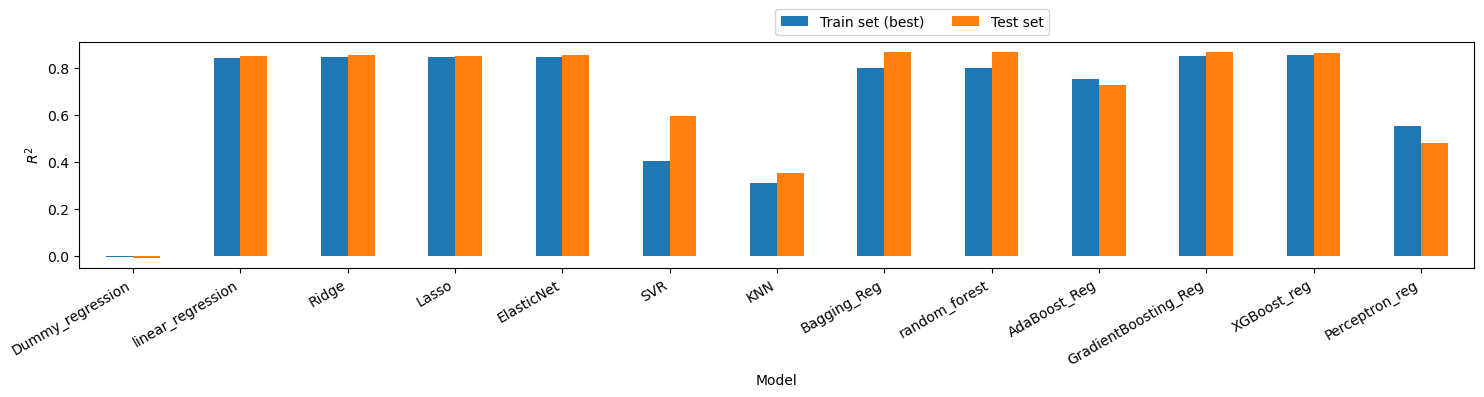

In [8]:
fig = plt.figure(figsize=(18,3),dpi=100)

Scores_Electricity[['model','top_score_train','R2_test']].plot(kind="bar", x='model', ax = plt.gca())
plt.legend(loc='lower right', labels=['Train set (best)', 'Test set'],ncol=2,bbox_to_anchor=(0.7, 1.0)
#title='Dataset :',
    )
plt.xlabel(xlabel='Model')
plt.ylabel(ylabel="$R^2$")
plt.xticks(rotation=30, ha='right')
plt.show()

### Optimisation du meilleur modèle

In [9]:
param_grid ={
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=42),
        'params' : {
        "max_leaf_nodes": [2, 5, 10, 20, 50],
        'max_depth': [1,2,3,4,5,10, 15,20],
        'subsample' : np.arange(0.1, 1.1, 0.1),
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    }
}



In [10]:
# L'algorithme de Gradient Boosting ne requiert pas une standardisation des données.
# Test de l'algorithme sur les données non standardisées :

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df.dropna()['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


Scores_Electricity = Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=10,random_state_cv=0, randomized_cv=True, randomized_n_iter= 200)
Scores_Electricity

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,GradientBoosting_Reg,"{'subsample': 0.7000000000000001, 'n_estimator...",0.874,243.135187,0.888,0.395,0.156,0.303


In [11]:
eval(Scores_Electricity.top_params[0])

{'subsample': 0.7000000000000001,
 'n_estimators': 278,
 'max_leaf_nodes': 5,
 'max_depth': 4,
 'learning_rate': 0.05}

In [12]:
# Enregristrement des meilleurs hyper-paramètres :

best_params = eval(Scores_Electricity.top_params[0])

In [13]:
# Entraînement du modèle définitif : 

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df.dropna()['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


GBR = GradientBoostingRegressor(random_state=42, **best_params)
GBR.fit(X_train, y_train)
y_pred=GBR.predict(X_test)


print("$R^2$ (Test Set) :", r2_score(y_test,y_pred).round(3))
print("MSE (Test Set) :", mean_squared_error(y_test,y_pred,squared=False).round(3))
print("RMSE (Test Set) :", mean_squared_error(y_test,y_pred).round(3))
print("MAE (Test Set) :", round(np.mean(abs(y_pred-y_test)), 3))

$R^2$ (Test Set) : 0.888
MSE (Test Set) : 0.395
RMSE (Test Set) : 0.156
MAE (Test Set) : 0.303


### Analyse de la courbe d'apprentissage

In [14]:
from sklearn.model_selection import learning_curve

# La courbe d'apprentissage (learning curve) permet de tester la précision du modèle sur des échantillons du dataframe de plus en plus grand. 
N, train_score, val_score = learning_curve(GBR, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=10)

train_score = pd.DataFrame(train_score, index = N).T.melt()
val_score = pd.DataFrame(val_score, index = N).T.melt()

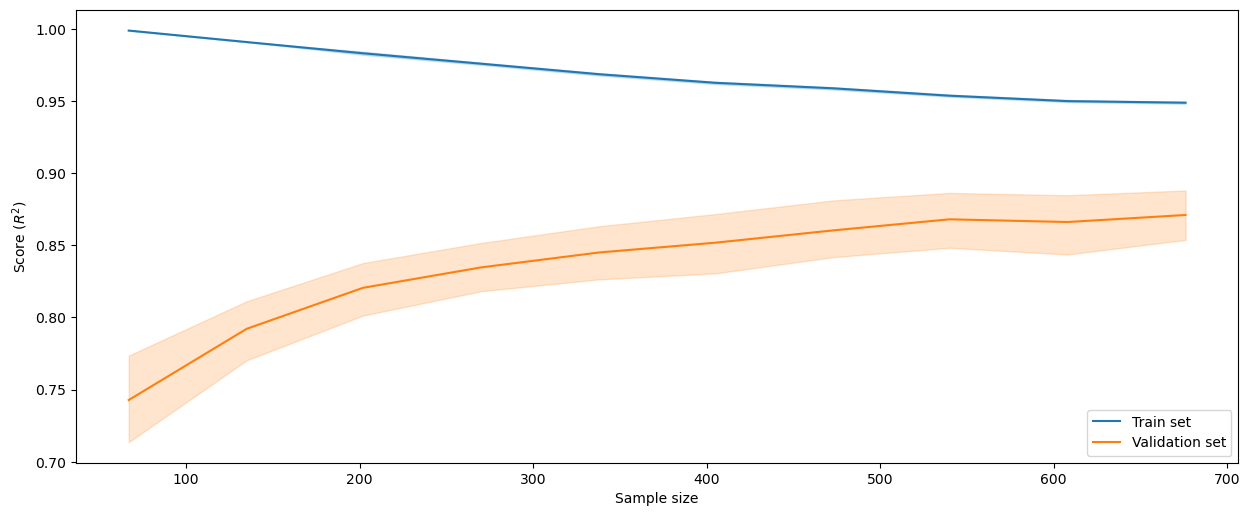

In [15]:

plt.figure(figsize=(15,6),dpi=100)
sns.lineplot(data= train_score, x="variable", y="value", label='Train set')
sns.lineplot(data= val_score, x="variable", y="value",label= 'Validation set')
#plt.xlim([0, 601])
plt.xlabel("Sample size")
plt.ylabel("Score ($R^2$)")
plt.legend(loc = 'lower right')
plt.show()



### Analyse de l'importance des variables

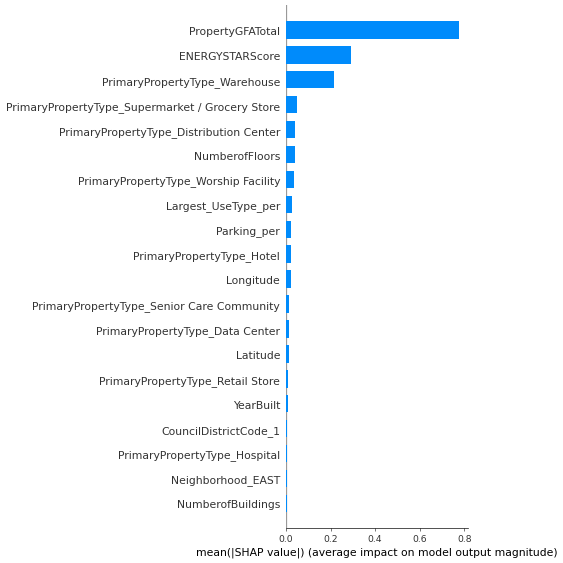

In [16]:
# L'importance des variables sera ici testé par la méthode de Shapley
# Plus la valeur SHAP est importante, plus la variable affecte la valeur prédite. 

shap_values = shap.TreeExplainer(GBR).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(GBR).shap_interaction_values(X_test)
plt.figure(figsize=(10,6),dpi=60)
shap.summary_plot(shap_values, X_test, plot_type="bar")


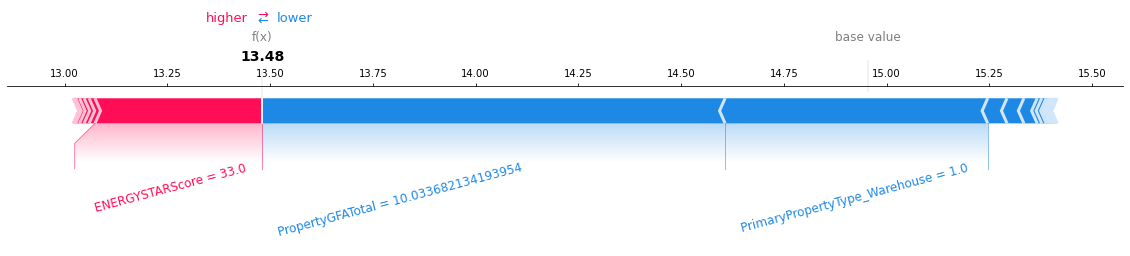

In [17]:
# Représentation de l'effet des variables sur un bâtiment

shap.initjs()
i = 100
shap.force_plot(shap.TreeExplainer(GBR).expected_value, shap_values[i], X_test.iloc[i,:],show=False,matplotlib=True,text_rotation=15).savefig('scratch.png')

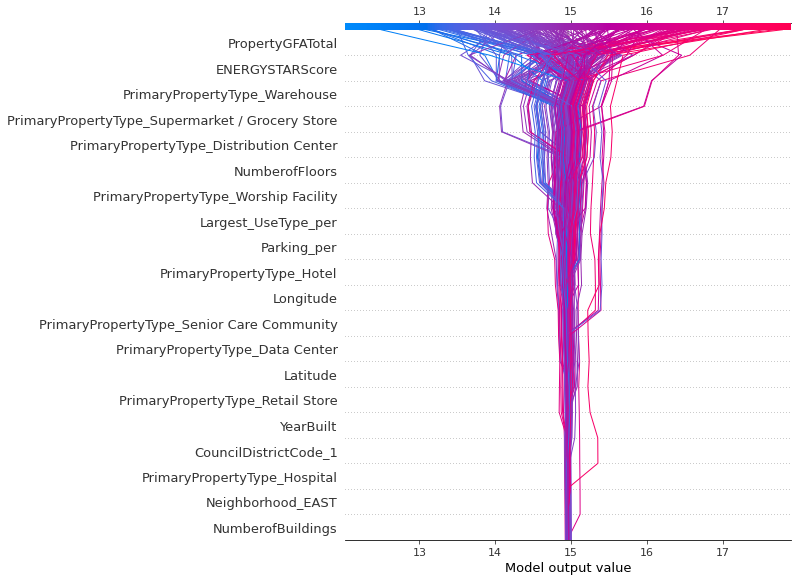

In [18]:
# Représentation de l'effet des variables sur tout le dataframe

shap.decision_plot(shap.TreeExplainer(GBR).expected_value, shap_values, features = X_test.columns)

In [19]:
# Entraînement du modèle sans la variable ENERGYSTARScore

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)','ENERGYSTARScore'])
y = df.dropna()['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

GBR2 = GradientBoostingRegressor(random_state=42, **best_params)
GBR2.fit(X_train, y_train)
y_pred2=GBR2.predict(X_test)


print("$R^2$ (Test Set) :", r2_score(y_test,y_pred2).round(3))
print("MSE (Test Set) :" , mean_squared_error(y_test,y_pred2,squared=False).round(3))
print("RMSE (Test Set) :", mean_squared_error(y_test,y_pred2).round(3))
print("MAE (Test Set) :", round(np.mean(abs(y_pred2-y_test)), 3))

$R^2$ (Test Set) : 0.793
MSE (Test Set) : 0.536
RMSE (Test Set) : 0.287
MAE (Test Set) : 0.406


### Analyse des valeurs prédites vs valeurs vraies

Text(0, 0.5, 'SiteEnergyUse (Thousand kBtu) : Predicted')

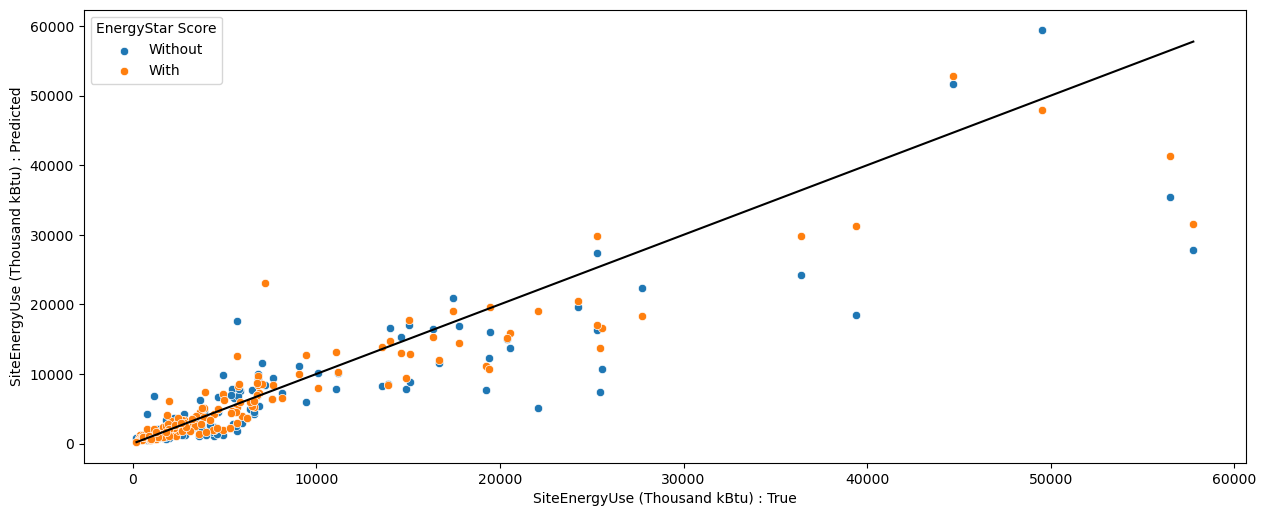

In [20]:

plt.figure(figsize=(15,6),dpi=100)

sns.scatterplot(x=np.expm1(y_test)/1000, y=np.expm1(y_pred2)/1000)
sns.scatterplot(x=np.expm1(y_test)/1000, y=np.expm1(y_pred)/1000)
plt.legend(title='EnergyStar Score', loc='upper left', labels=['Without', 'With'])
sns.lineplot(x=np.expm1(y_test)/1000, y=np.expm1(y_test)/1000,color="black")

plt.xlabel("SiteEnergyUse (Thousand kBtu) : True")
plt.ylabel("SiteEnergyUse (Thousand kBtu) : Predicted")